In [1]:
library(Signac)
library(Seurat)
library(ggplot2)
library(ggrepel)
library(viridis)
library(zoo)
# library(pheatmap)
library(ComplexHeatmap)
library(harmony)
library(dplyr)
library(tidyr)
library(TFBSTools)
library(motifmatchr)
library(reshape2)
# library(qlcMatrix)
library(GenomicRanges)
library(JASPAR2020)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
set.seed(1234)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: viridisLite


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed 

# peak to link

In [2]:
Process_RNA <- function(proj=proj, nfeatures=2000, pc.nums=50, dims=1:50, pca.name = 'pca', umap.name= 'umap.rna', res = 0.8){
  DefaultAssay(proj) <- "RNA"
  #
  proj <- NormalizeData(proj)
  proj <- FindVariableFeatures(proj, nfeatures = nfeatures)
  VariableFeatures(proj) <- VariableFeatures(proj)[!VariableFeatures(proj) %in% blacklist.genes]
  proj <- ScaleData(proj)
  proj <- RunPCA(proj, npcs = pc.nums, reduction.name = pca.name)
  #
  return(proj)
}

GetBlackListGenes <- function (proj = proj, MT = TRUE, Ribo = TRUE, Cellcycle = TRUE, Sex = TRUE) {
    mt.genes <- grep(pattern = "^MT-", x = rownames(proj), value = TRUE)
    ribosome.genes <- grep(pattern = "^RP[SL][[:digit:]]|^RP[[:digit:]]|^RPSA", 
        rownames(proj), value = TRUE)
    s.genes <- cc.genes$s.genes
    g2m.genes <- cc.genes$g2m.genes
    txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
    geneGR <- GenomicFeatures::genes(txdb)
    sexGenesGR <- geneGR[seqnames(geneGR) %in% c("chrY", "chrX")]
    matchedGeneSymbols <- AnnotationDbi::select(org.Mm.eg.db, 
        keys = sexGenesGR$gene_id, columns = c("ENTREZID", "SYMBOL"), keytype = "ENTREZID")
    sexChr.genes <- matchedGeneSymbols$SYMBOL
    vector_genes = c(MT, Ribo, Sex, Cellcycle, Cellcycle)
    order_num = c()
    for (i in 1:length(vector_genes)) {
        if (isTRUE(vector_genes[i])) {
            order_num <- c(order_num, i)
        }
    }
    blacklist.genes <- list(mt.genes, ribosome.genes, sexChr.genes, s.genes, g2m.genes)[order_num]
    blacklist.genes <- do.call(c, blacklist.genes)
    return(blacklist.genes)
}

In [3]:
seu <- readRDS('./03_Skin/Mskin_atac_rna_processed.rds')
fibroblasts <- seu[, seu@meta.data$rna_celltype %in% c("Fibroblasts","Chod","Dermal_papilla")]

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

'select()' returned 1:1 mapping between keys and columns

Centering and scaling data matrix

PC_ 1 
Positive:  Col1a1, Krt10, Krt1, Cmss1, Postn, Itih5, Cstdc5, Hrnr, Egr1, Btg2 
	   Cntn4, Gm19951, Abi3bp, Cxcl1, Flg, Col14a1, Lpl, Gm32647, Tnxb, Col5a3 
	   Cyp26b1, Pparg, Cxcl2, Il1r1, Cd55, Cd36, Cxcl10, Clec3b, Col6a6, Il6 
Negative:  Mir100hg, Mdga2, Fbxl7, Pcdh9, Ptprd, Aff3, Nebl, Tenm3, Hmcn1, Magi2 
	   Spock3, Foxp2, Adgrl3, Auts2, Zfhx3, Ctnna2, Cacna2d3, Gm48742, Akap12, Efna5 
	   Lrrc7, Flrt2, Adamtsl1, Prkg1, Eml4, Bnc2, Sdk1, Alcam, Tpm1, Zfhx4 
PC_ 2 
Positive:  Robo2, Tmem132c, Pde7b, Twist2, Ednra, Nebl, Tbx15, Masp1, Itga8, Tex15 
	

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21712
Number of edges: 716316

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.9343
Number of communities: 5
Elapsed time: 34 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21712
Number of edges: 716316

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8838
Number of communities: 6
Elapsed time: 28 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21712
Number of edges: 716316

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8472
Number of communities: 9
Elapsed time: 24 seconds


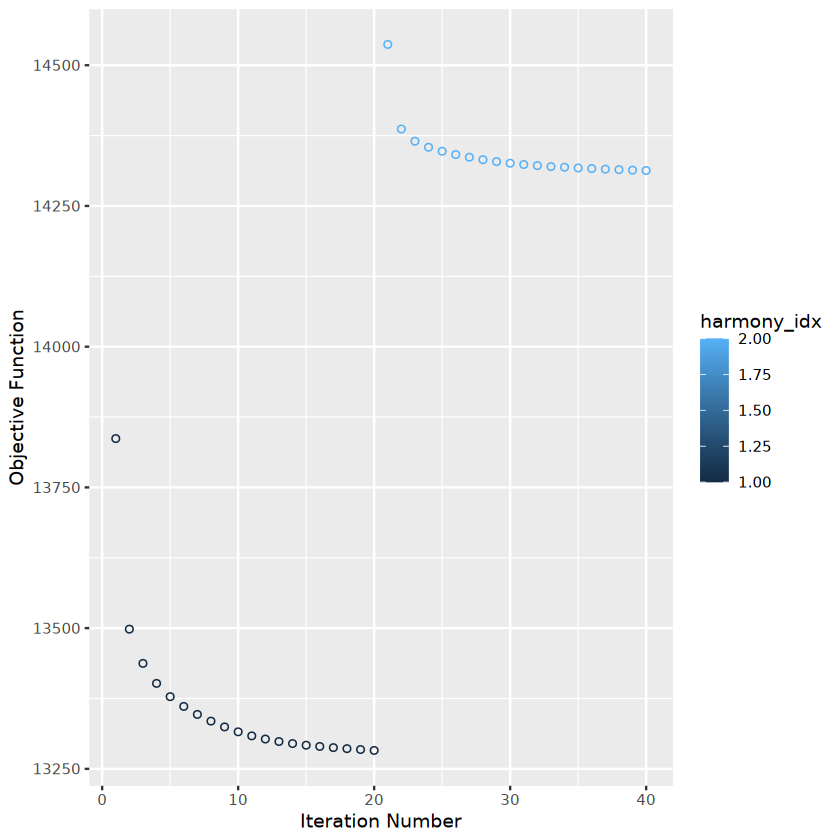

In [4]:
###### RNA process #######
DefaultAssay(fibroblasts) <- 'RNA'
# get blacklist genes
blacklist.genes=GetBlackListGenes(fibroblasts, MT=TRUE, Ribo=TRUE, Cellcycle=FALSE, Sex=FALSE)
# process
fibroblasts=Process_RNA(fibroblasts)
# run harmony
var_int <- c("batch") # , "stage"
fibroblasts <- RunHarmony(fibroblasts, group.by.vars = var_int, assay.use="RNA", reduction = "pca", plot_convergence = TRUE)
red_use <- "harmony"
dims_use <- 1:30
nneigh <- 40
fibroblasts <- RunUMAP(fibroblasts, reduction = red_use, dims = dims_use,n.neighbors = nneigh)
fibroblasts <- FindNeighbors(fibroblasts, verbose = T, reduction = red_use, dims = dims_use)
fibroblasts <- FindClusters(fibroblasts, verbose = T, algorithm = 3, resolution = c(0.1, 0.3, 0.5))

In [5]:
####### ATAC process ##########
DefaultAssay(fibroblasts) <- "ATAC"
#LSI reduction
fibroblasts<- RunTFIDF(fibroblasts)
fibroblasts <- FindTopFeatures(fibroblasts, min.cutoff = 'q50')
fibroblasts <- RunSVD(fibroblasts)
# run harmony
var_int <- "batch"
fibroblasts <- RunHarmony(fibroblasts, group.by.vars = var_int, assay.use="ATAC", reduction = "lsi", reduction.save = 'harmony_lsi', project.dim = FALSE)
# create a new UMAP using the integrated embeddings
fibroblasts <- RunUMAP(fibroblasts, reduction = 'harmony_lsi', dims = c(2:26), reduction.name = "umap.atac", reduction.key = "atacUMAP_")
fibroblasts <- FindNeighbors(fibroblasts, reduction = 'harmony_lsi', dims = c(2:26), n.neighbors = 40)
fibroblasts <- FindClusters(fibroblasts, verbose = FALSE, algorithm = 3, resolution = c(0.1, 0.3, 0.5))

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

16:14:00 UMAP embedding parameters a = 0.9922 b = 1.112

16:14:00 Read 21712 rows and found 25 numeric columns

16:14:00 Using Annoy for neighbor search, n_neighbors = 30

16:14:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:14:04 Writing NN index file to temp file /jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/zhangzhongjin/RTEMP/RtmpY1Fbdf/file4d503ecbcdb9

16:14:04 Searching Annoy index using 1 thread, search_k = 3000

16:14:14 Annoy recall = 100%

16:14:17 Commencing smooth kNN distance

In [6]:
# SCT
DefaultAssay(fibroblasts) <- "RNA"
fibroblasts <- SCTransform(fibroblasts, vars.to.regress = "percent.mt", verbose = FALSE)
# chromVAR
DefaultAssay(fibroblasts) <- "ATAC"
pfm <- getMatrixSet(x = JASPAR2020, opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)) # 投递
fibroblasts <- AddMotifs(object = fibroblasts, genome = BSgenome.Mmusculus.UCSC.mm10, pfm = pfm)
fibroblasts <- RunChromVAR(object = fibroblasts, genome = BSgenome.Mmusculus.UCSC.mm10)
# saveRDS(fibroblasts,'./04_Skin_Fibroblast/skin_fibro_proce.rds')

Warning message:
"Different cells and/or features from existing assay SCT"
Building motif matrix

Finding motif positions

Creating Motif object

Computing GC bias per region

Selecting background regions

Computing deviations from background



In [7]:
fibroblasts <- readRDS('./04_Skin_Fibroblast_Fibrblast/skin_fibro_proce.rds')

In [8]:
# findmarker
markers_rna <- presto:::wilcoxauc.Seurat(fibroblasts, group_by = 'stage', assay = 'data', seurat_assay = 'SCT')
markers_motifs <- presto:::wilcoxauc.Seurat(fibroblasts, group_by = 'stage', assay = 'data', seurat_assay = 'chromvar')
colnames(markers_rna) <- paste0("RNA.", colnames(markers_rna))
colnames(markers_motifs) <- paste0("motif.", colnames(markers_motifs))
#
markers_rna$gene <- markers_rna$RNA.feature
DefaultAssay(fibroblasts) <- 'ATAC'
markers_motifs$gene <- ConvertMotifID(fibroblasts, id = markers_motifs$motif.feature)

In [9]:
markers_motifs$gene <- gsub("\\(var.2)|\\(var.3)","",markers_motifs$gene)
markers_motifs <- markers_motifs %>% mutate(gene = strsplit(gene, "::")) %>% unnest(gene)
markers_motifs <- data.frame(markers_motifs)
markers_motifs$gene <- unlist(lapply(markers_motifs$gene,function(x){
        paste0(toupper(substr(x, 1, 1)), tolower(substr(x, 2, nchar(x))))
})) 
topTFs <- function(stage, padj.cutoff = 0.05) {
        ctmarkers_rna <- dplyr::filter(
                markers_rna, RNA.group == stage, RNA.padj < padj.cutoff, RNA.logFC > 0) %>% 
                arrange(-RNA.auc)
        ctmarkers_motif <- dplyr::filter(
                markers_motifs, motif.group == stage, motif.padj < padj.cutoff, motif.logFC > 0) %>% 
                arrange(-motif.auc)
        top_tfs <- inner_join(
                x = ctmarkers_rna[, c(2, 11, 6, 7)], 
                y = ctmarkers_motif[, c(2, 1, 11, 6, 7)], by = "gene"
        )
        top_tfs$avg_auc <- (top_tfs$RNA.auc + top_tfs$motif.auc) / 2
        top_tfs <- arrange(top_tfs, -avg_auc)
        return(top_tfs)
}  
head(topTFs("E13"), 3)

,RNA.group,gene,RNA.auc,RNA.pval,motif.group,motif.feature,motif.auc,motif.pval,avg_auc
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,E13,Lef1,0.5667792,9.642978e-76,E13,MA0768.1,0.8525743,0,0.7096767
2,E13,Tead1,0.6208954,6.547408e-171,E13,MA0090.3,0.7962557,0,0.7085755
3,E13,Tcf4,0.6757556,0.000000e+00,E13,MA0830.2,0.6907302,0,0.6832429


In [10]:
# Find DEGs bw clusters ####
DefaultAssay(fibroblasts) <- "SCT"
Idents(fibroblasts) <- fibroblasts$stage
de_genes <- FindAllMarkers(fibroblasts,only.pos = T,logfc.threshold = 0.1,max.cells.per.ident = 1000)

Calculating cluster E13

Calculating cluster E14

Calculating cluster E16

Calculating cluster E15

Calculating cluster E18



In [11]:
# Linking peaks to genes ####
DefaultAssay(fibroblasts) <- "ATAC"
fibroblasts <- RegionStats(fibroblasts, genome = BSgenome.Mmusculus.UCSC.mm10)
deg <- unique(de_genes[de_genes$p_val_adj<0.05 & de_genes$avg_log2FC>0.1,'gene'])
fibroblasts <- LinkPeaks(fibroblasts,peak.assay = "ATAC",expression.assay = "SCT",genes.use = deg) # 非常耗时 投递处理
link <- Links(fibroblasts)
link <- data.frame(link)
link$adj_pval <- p.adjust(link$pvalue,method = 'BH')
link$stage <- de_genes[match(link$gene,de_genes$gene),'cluster']
lvl <- c('E13','E14','E15','E16','E18')   # lvl <- levels(fibroblasts)
link$stage <- factor(link$stage,levels=lvl)   
link <- arrange(link,factor(stage,levels=lvl))
link <- link[link$adj_pval<0.05 & link$score>0,]
t <- link %>% group_by(gene) %>% summarise(n=n())
summary(t$n)

Testing 1815 genes and 168171 peaks

Found gene coordinates for 1711 genes



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.825   5.000  28.000 

In [12]:
top_genes_per_cluster <- list()
for (cluster in lvl) {
  # 
  cluster_genes <- de_genes[de_genes$cluster == cluster, ]
  
  # 
  top_genes_per_cluster[[cluster]] <- cluster_genes[1:20, ]
}
# write.csv(x,file="./04_Skin_Fibroblast_Fibrblast/da_genes_fibro_top20.csv")

In [13]:
gene.use <- unique(link$gene)
DefaultAssay(fibroblasts) <- "RNA"
# 
cc.genes
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
fibroblasts <- CellCycleScoring(fibroblasts, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE) 
fibroblasts <- ScaleData(fibroblasts,vars.to.regress = c("S.Score", "G2M.Score"),features=gene.use)
rna <- fibroblasts@assays$RNA@scale.data[gene.use,]
asplit_cells <- split(colnames(fibroblasts), fibroblasts$stage)
n <- 10
means <- do.call(cbind, lapply(lvl, function(x){
        df <- rna[,asplit_cells[[x]]]
        t(apply(df,1,function(x){rollapply(x,n,mean,by=n)}))
}))
stage <- unlist(lapply(lvl, function(x) rep(x, length(asplit_cells[[x]])%/%n)))
anno_col <- data.frame(stage)
rownames(anno_col) <- colnames(means) <- paste0(seq(1:ncol(means)),colnames(means))
anno_col$stage <- factor(anno_col$stage,levels=lvl) 
anno_col <- arrange(anno_col,factor(stage,levels=lvl))

$s.genes
 [1] "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    
 [7] "RRM1"     "UNG"      "GINS2"    "MCM6"     "CDCA7"    "DTL"     
[13] "PRIM1"    "UHRF1"    "MLF1IP"   "HELLS"    "RFC2"     "RPA2"    
[19] "NASP"     "RAD51AP1" "GMNN"     "WDR76"    "SLBP"     "CCNE2"   
[25] "UBR7"     "POLD3"    "MSH2"     "ATAD2"    "RAD51"    "RRM2"    
[31] "CDC45"    "CDC6"     "EXO1"     "TIPIN"    "DSCC1"    "BLM"     
[37] "CASP8AP2" "USP1"     "CLSPN"    "POLA1"    "CHAF1B"   "BRIP1"   
[43] "E2F8"    

$g2m.genes
 [1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

Warning message:
"The following features are not present in the object: MCM5, PCNA, TYMS, FEN1, MCM2, MCM4, RRM1, UNG, GINS2, MCM6, CDCA7, DTL, PRIM1, UHRF1, MLF1IP, HELLS, RFC2, RPA2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, MSH2, ATAD2, RAD51, RRM2, CDC45, CDC6, EXO1, TIPIN, DSCC1, BLM, CASP8AP2, USP1, CLSPN, POLA1, CHAF1B, BRIP1, E2F8, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: HMGB2, CDK1, NUSAP1, UBE2C, BIRC5, TPX2, TOP2A, NDC80, CKS2, NUF2, CKS1B, MKI67, TMPO, CENPF, TACC3, FAM64A, SMC4, CCNB2, CKAP2L, CKAP2, AURKB, BUB1, KIF11, ANP32E, TUBB4B, GTSE1, KIF20B, HJURP, CDCA3, HN1, CDC20, TTK, CDC25C, KIF2C, RANGAP1, NCAPD2, DLGAP5, CDCA2, CDCA8, ECT2, KIF23, HMMR, AURKA, PSRC1, ANLN, LBR, CKAP5, CENPE, CTCF, NEK2, G2E3, GAS2L3, CBX5, CENPA, not searching for symbol synonyms"
Warning message in AddModuleScore(object = object, features = features, name = name, :
"Could not find enough features in the object 

Warning message:
"It not suggested to both set `scale` and `breaks`. It makes the
function confused."
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



null device 
          1

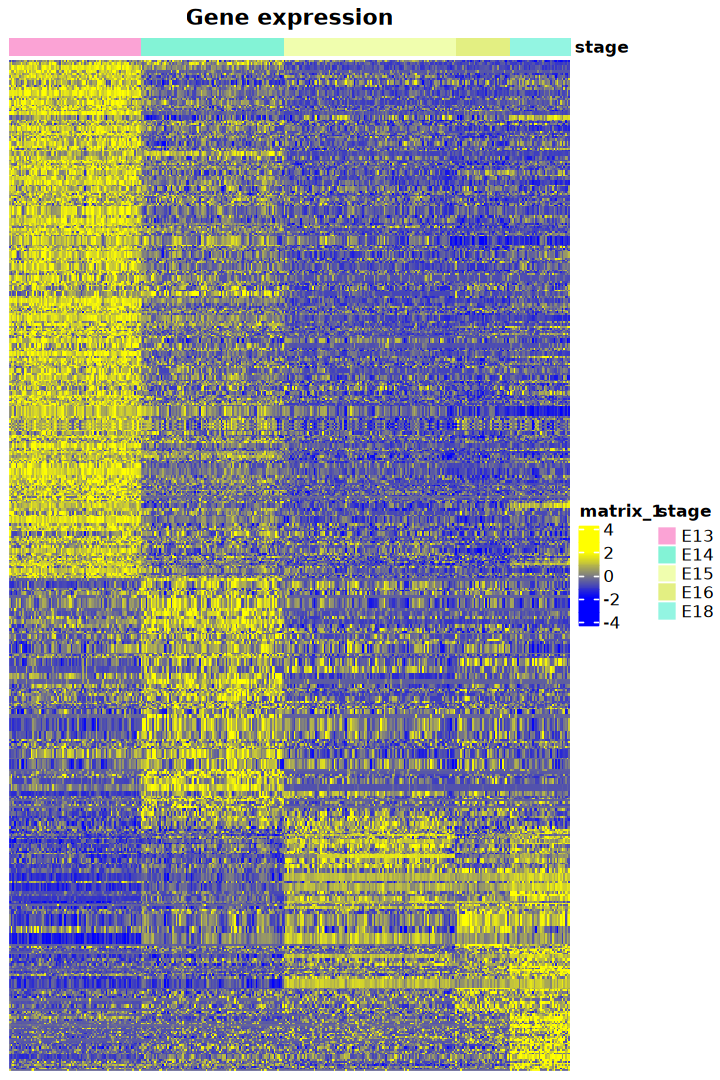

In [14]:
options(repr.plot.width = 6, repr.plot.height = 9)
# yellow2blue = colorRampPalette(colors = c("blue","black","yellow"))(100)
BluYl = colorRampPalette(colors = c("blue","yellow"))(100)
label_colors <- list(celltype_major=c('E13' = '#53A85F','E14' = '#F1BB72','E15' = '#F3B1A0','E16' = '#D6E7A3','E18' = '#57C3F3'))
p1 = pheatmap(means[link$gene,rownames(anno_col)], cluster_rows = F, cluster_cols = F, scale = "row", show_rownames = F,
         breaks = seq(-2, 2, length = 101), col = BluYl,
         annotation_col = anno_col,show_colnames = F, annotation_colors = label_colors, use_raster = TRUE,
         main='Gene expression')
# pdf('./04_Skin_Fibroblast_Fibrblast/peak_gene_fibro_gene.pdf',width=6,height=9)
p1
dev.off()

In [15]:
peak.use <- unique(link$peak)
DefaultAssay(fibroblasts) <- "ATAC"
Idents(fibroblasts) <- 'stage'
atac <- RunTFIDF(fibroblasts@assays$ATAC@counts[peak.use,])
asplit_cells <- split(colnames(fibroblasts), fibroblasts$stage)
means_peak <- do.call(cbind, lapply(lvl, function(x){
        df <- atac[,asplit_cells[[x]]]
        t(apply(df,1,function(x){rollapply(x,n,mean,by=n)}))
}))
#
celltype_major <- unlist(lapply(lvl, function(x) rep(x, length(asplit_cells[[x]])%/%n)))
anno_col2 <- data.frame(celltype_major)
rownames(anno_col2) <- colnames(means_peak) <- paste0(seq(1:ncol(means_peak)),colnames(means_peak))
anno_col2 <- arrange(anno_col2,factor(celltype_major,levels=lvl))

Performing TF-IDF normalization



Warning message:
"It not suggested to both set `scale` and `breaks`. It makes the
function confused."
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



null device 
          1

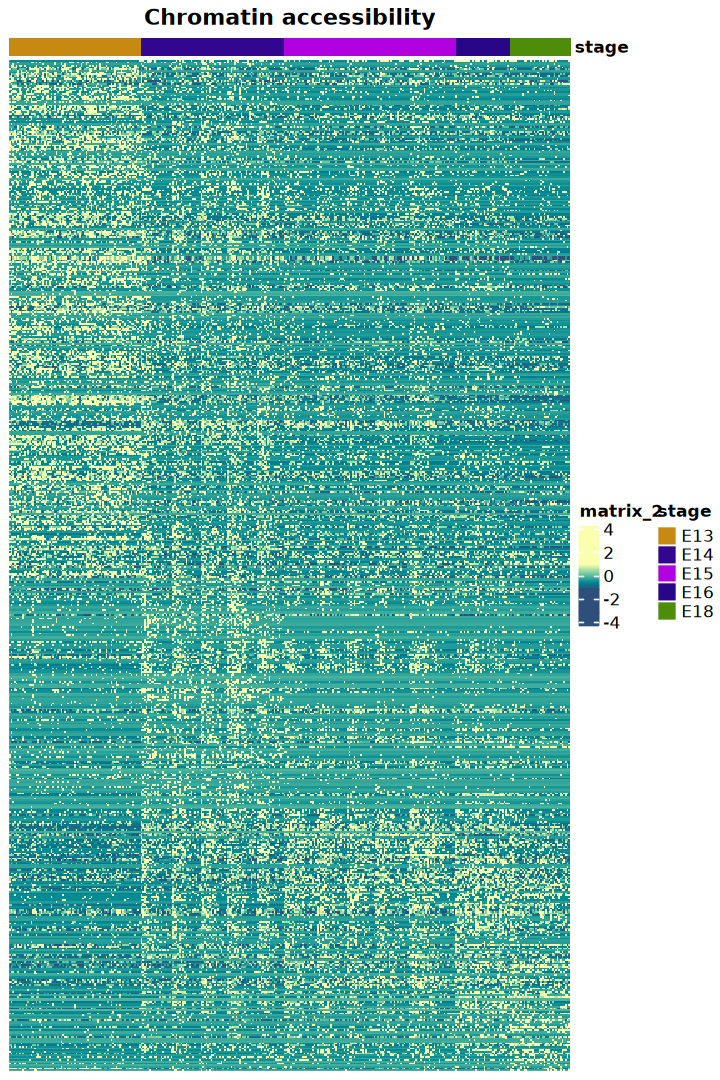

In [16]:
options(repr.plot.width = 6, repr.plot.height = 9)
p2 = pheatmap(means_peak[link$peak,rownames(anno_col2)],cluster_rows = F, cluster_cols = F, scale = "row", show_rownames = F,
               breaks = seq(-1.2, 0.9, length = 101), color = hcl.colors(100, "BluYl"),
               annotation_col = anno_col, show_colnames = F, annotation_colors = label_colors, use_raster=TRUE,
               main='Chromatin accessibility')
# pdf('./04_Skin_Fibroblast_Fibrblast/peak_gene_fibro_peak.pdf',width=6,height=9)
p2
dev.off()

* GO-term

In [17]:
gene <- link[, c('gene','stage')]
gene <- unique(gene)

In [18]:
table(gene$stage)


E13 E14 E15 E16 E18 
296  92  26  65  48 

In [19]:
E13 <- gene[gene$stage == 'E13', 'gene']
E14 <- gene[gene$stage == 'E14', 'gene']
E15 <- gene[gene$stage == 'E15', 'gene']
E16 <- gene[gene$stage == 'E16', 'gene']
E18 <- gene[gene$stage == 'E18', 'gene']

In [20]:
E18 <- data.frame(E18 = gene[gene$stage == 'E18', 'gene'])
# write.table(E18,"./04_Skin_Fibroblast_Fibrblast/skin_fibro_E18.tsv",row.names=FALSE,col.names=TRUE,sep="\t")

GO-term analysis (E15/E16/E18) using web (http://great.stanford.edu/public/html/), respectively

In [21]:
fibro_goterm <- read.csv('./04_Skin_Fibroblast/skin_fibro_goterm.csv')
fibro_goterm

stage,Description,X.LogP,Log.q.value.,ratio
<chr>,<chr>,<dbl>,<dbl>,<dbl>
E13,cell-cell adhesion,12.904043,-9.489,0.067391304
E13,extracellular matrix organization,12.359415,-9.032,0.086330935
E13,embryonic morphogenesis,8.533801,-5.842,0.046439628
E13,regulation of Wnt signaling pathway,7.836465,-5.301,0.061728395
E13,muscle structure development,7.481730,-4.985,0.046594982
E13,embryonic organ development,6.107500,-3.740,0.043233083
E13,Collagen formation,4.403056,-2.336,0.100000000
E14,connective tissue development,16.409888,-12.150,0.069767442
E14,Collagen formation,6.260054,-3.279,0.085714286


In [22]:
#
fibro_goterm[9,2] = 'Collagen formation1'
fibro_goterm[17,2] = 'connective tissue development1'
# 
fibro_goterm$Description <- factor(fibro_goterm$Description, levels=c('Laminin interactions','cellular response to lipid','connective tissue development1','skin development','collagen fibril organization','Collagen chain trimerization',
                                                                      'epidermis development','Cytoskeleton in muscle cells - Mus musculus (house mouse)','stem cell differentiation','post-embryonic development','Collagen formation1',
                                                                      'connective tissue development','Collagen formation','embryonic organ development','muscle structure development','regulation of Wnt signaling pathway','embryonic morphogenesis',
                                                                      'extracellular matrix organization','cell-cell adhesion'))

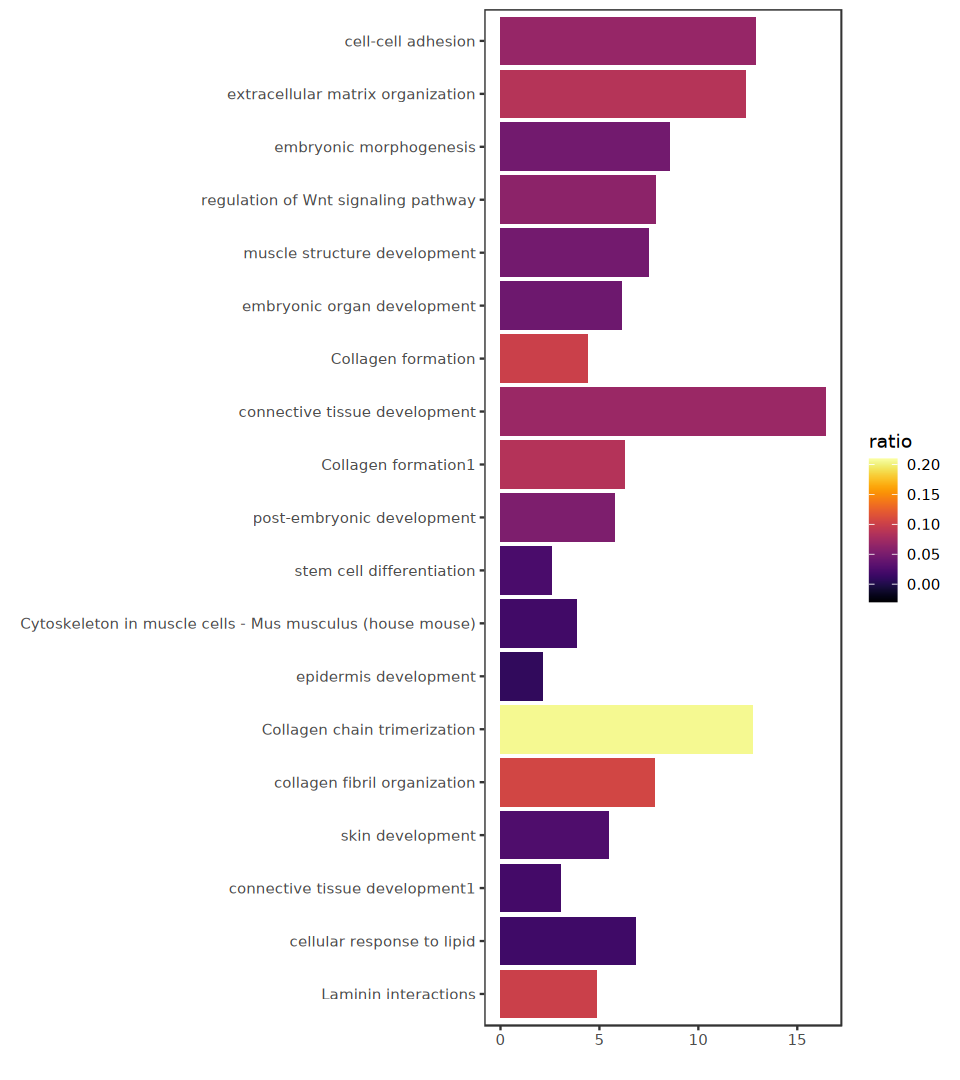

In [23]:
options(repr.plot.width = 8, repr.plot.height = 9)
p3= ggplot(fibro_goterm[order(fibro_goterm$Description), ], aes(Description, X.LogP)) + geom_col(aes(fill=ratio))+ scale_fill_viridis(limits = c(-0.03, 0.21),option = "B")+
coord_flip() + theme_bw()  +
theme(panel.grid.major=element_line(colour=NA),panel.background = element_rect(fill = "transparent",colour = NA),
      plot.background = element_rect(fill = "transparent",colour = NA),panel.grid.minor = element_blank()) + xlab("") + ylab("")
p3

# trajectory driver gene

In [24]:
skin_fib <- readRDS('./04_Skin_Fibroblast/Skin_fibroblast.rds')

In [25]:
colnames(skin_fib@meta.data)

In [26]:
# 
Idents(object = skin_fib) <- "RNA_snn_res.0.5"
levels(skin_fib) <- c('0', '1', '2', '3', '4', '5', '6', '7', '8')
new.cluster.ids <- c('Fib.Lower', 'Fib.Upper', 'Fib.Origin', 'Fib.Muscle', 'Fib.Inter', 'Fib.Deep', 'Chod', 'Fib.DC', 'Fib.Deep')
names(new.cluster.ids) <- levels(skin_fib)
skin_fib <- RenameIdents(skin_fib, new.cluster.ids)
skin_fib$celltype_sub=Idents(skin_fib)
options(repr.plot.width=4, repr.plot.height=4)
DimPlot(skin_fib, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [27]:
Idents(skin_fib) <- 'celltype_sub'
seu = subset(skin_fib, ident=c('Fib.Lower', 'Fib.Upper', 'Fib.Origin', 'Fib.Muscle', 'Fib.Inter', 'Fib.Deep', 'Fib.DC', 'Fib.Deep'))
# saveRDS(skin_fib,'./04_Skin_Fibroblast_Fibrblast/Mskin_fib.rds')

In [28]:
# SCT
DefaultAssay(seu) <- "RNA"
seu <- SCTransform(seu, vars.to.regress = "percent.mt", verbose = FALSE)
# chromVAR
DefaultAssay(seu) <- "ATAC"
pfm <- getMatrixSet(x = JASPAR2020, opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE))
seu <- AddMotifs(object = seu, genome = BSgenome.Mmusculus.UCSC.mm10, pfm = pfm)
seu <- RunChromVAR(object = seu, genome = BSgenome.Mmusculus.UCSC.mm10)
saveRDS(seu,'./04_Skin_Fibroblast_Fibrblast/Mskin_fib_tracproce.rds')

In [29]:
seu <- readRDS('./04_Skin_Fibroblast/Mskin_fib_proce_nonchod.rds')

In [30]:
# read diffusion_pseudotime, terminal_prob, and transition_Fib information
skin_fib_meta <- read.csv('./04_Skin_Fibroblast/Mskin_fib_meta.csv',sep='\t',header = TRUE,row.names=1)
colnames(skin_fib_meta) <- c('diffusion_pseudotime','terminal_prob', 'transition_Fib.DC','transition_Fib.Deep','transition_Fib.Inter','transition_Fib.Lower') 
seu@meta.data <- cbind(seu@meta.data, skin_fib_meta) # 加入seurat对象中

In [31]:
skin_fib_meta

,diffusion_pseudotime,terminal_prob,transition_Fib.DC,transition_Fib.Deep,transition_Fib.Inter,transition_Fib.Lower
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
E13_HU1_BC0177_N02,0.028299964,0.2183137,0.5137490,0.14326896,0.07031119,0.2726692
E13_HU1_BC0227_N02,0.468864673,0.7797730,0.4969879,0.02639032,0.17832251,0.2982979
E13_HU1_BC0232_N01,0.150046740,0.5128302,0.4827400,0.10197850,0.13306935,0.2822114
E13_HU1_BC0253_N01,0.074116526,0.3971090,0.5466174,0.10217554,0.06595419,0.2852511
E13_HU1_BC0273_N03,0.195369061,0.5549308,0.5649270,0.08360102,0.05887597,0.2925944
E13_HU1_BC0276_N02,0.066783783,0.3396229,0.5475136,0.09834072,0.06815970,0.2859839
E13_HU1_BC0311_N01,0.074377219,0.2668043,0.4732806,0.18510074,0.08235456,0.2592631
E13_HU1_BC0325_N02,0.120058390,0.4332755,0.5624088,0.08149417,0.06497315,0.2911219
E13_HU1_BC0333_N01,0.141209152,0.2831599,0.5020592,0.14859736,0.07718373,0.2721584


In [32]:
driver_gene <- read.csv('./04_Skin_Fibroblast/Mskin_fib_drivergene.csv',header = TRUE)
rownames(driver_gene) = driver_gene$X
#
driver_DC <- driver_gene[, grep("Fib.DC",colnames(driver_gene))]
driver_Deep <- driver_gene[, grep("Fib.Deep",colnames(driver_gene))]
driver_Inter <- driver_gene[, grep("Fib.Inter",colnames(driver_gene))]
driver_Lower <- driver_gene[, grep("Fib.Lower",colnames(driver_gene))]
# 
driver_DC <- driver_DC[order(driver_DC$Fib.DC_pval), ]
driver_Deep <- driver_Deep[order(driver_Deep$Fib.Deep_pval), ]
driver_Inter <- driver_Inter[order(driver_Inter$Fib.Inter_pval), ]
driver_Lower <- driver_Lower[order(driver_Lower$Fib.Lower_pval), ]

In [33]:
# add stage
seu$stage1 <- gsub("^E", "", seu$stage)
seu$stage1 <- as.numeric(seu$stage1)

In [34]:
############### fib.DC ###################
seu$tmp <- seu$transition_Fib.DC > summary(seu$transition_Fib.DC)['Mean']
tmp <- seu[,seu$tmp]
corr.thres <- 0.05
Fib.DC <- na.omit(driver_DC[order(driver_DC$Fib.DC_corr,decreasing = T),]) 
Fib.DC$adjusted_pval <- p.adjust(Fib.DC$Fib.DC_pval,method="BH") 
Fib.DC <- Fib.DC[Fib.DC$adjusted_pval < 0.05 & Fib.DC$Fib.DC_corr > corr.thres,]
# saveRDS(tmp,'./04_Skin_Fibroblast_Fibrblast/Mskin_fib_DC.rds')

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


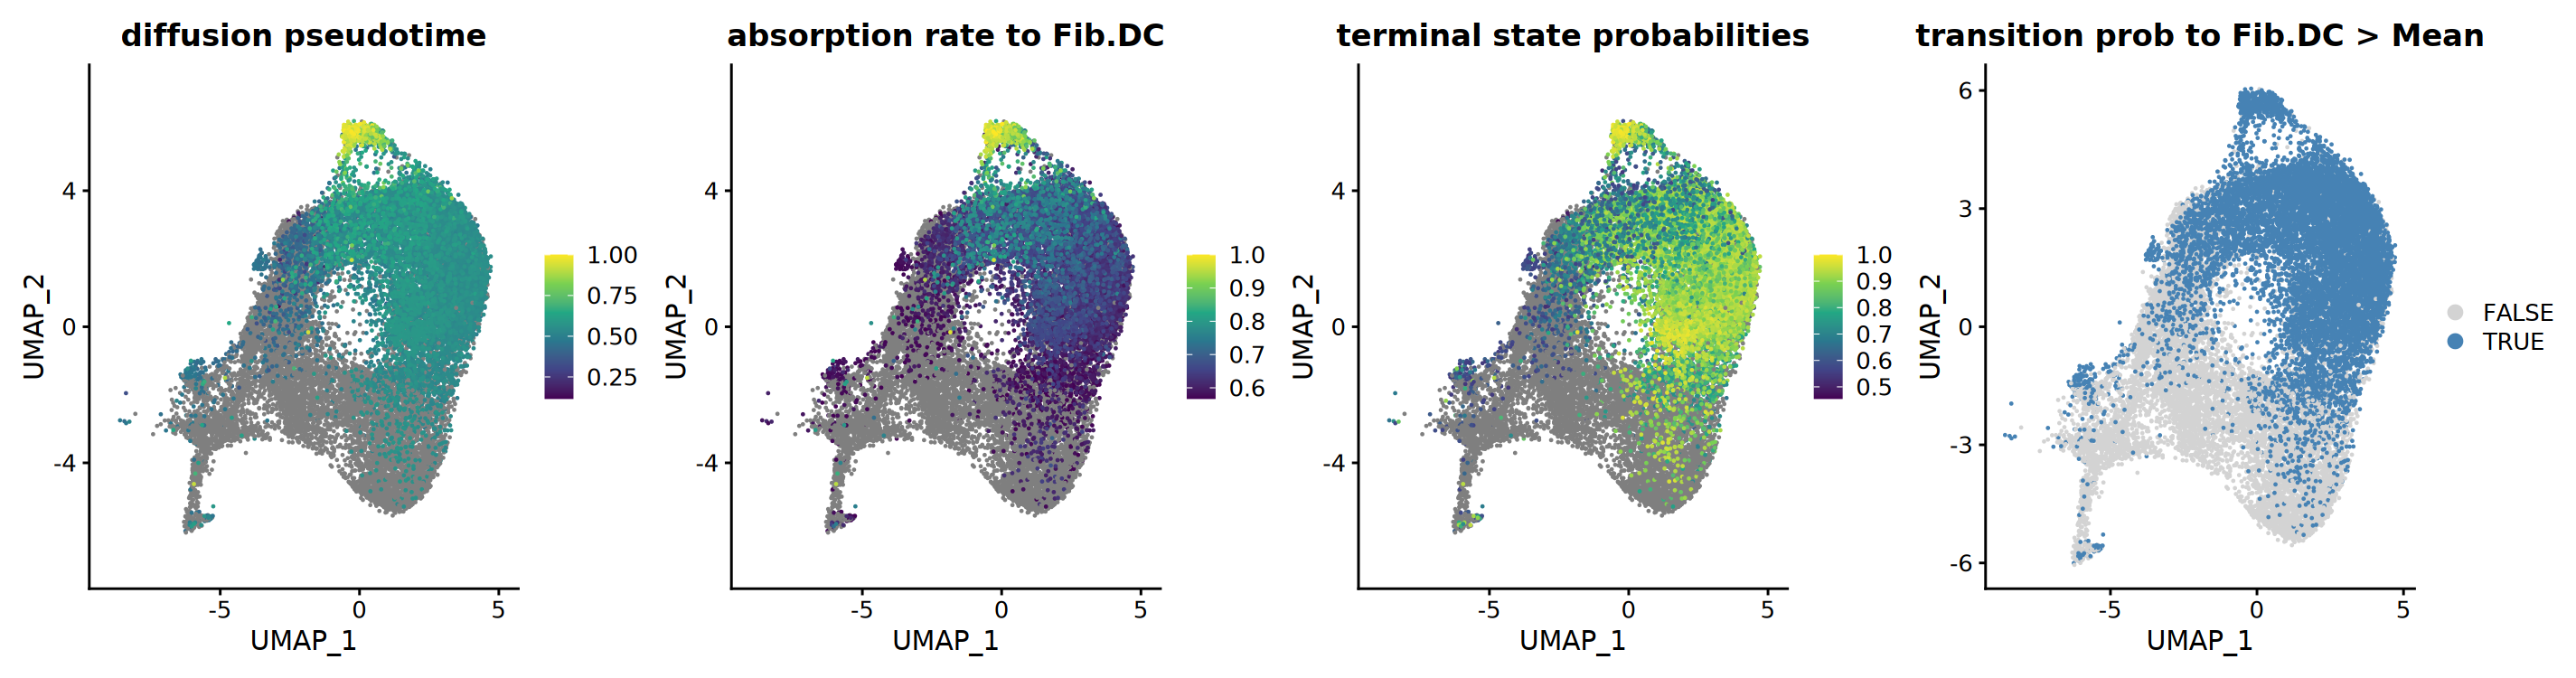

In [35]:
options(repr.plot.width=19, repr.plot.height=5, repr.plot.res = 150)
seu$tmp1 <- seu$diffusion_pseudotime
seu$tmp1[!(colnames(seu) %in% colnames(tmp))] <- NA
p1 <- FeaturePlot(seu, 'tmp1',reduction="umap") & scale_color_viridis_c() & labs(title="diffusion pseudotime")
seu$tmp1 <- seu$transition_Fib.DC
seu$tmp1[!(colnames(seu) %in% colnames(tmp))] <- NA
p2 <- FeaturePlot(seu, 'tmp1',reduction="umap") & scale_color_viridis_c() & labs(title="absorption rate to Fib.DC")
seu$tmp1 <- seu$terminal_prob
seu$tmp1[!(colnames(seu) %in% colnames(tmp))] <- NA
p3 <- FeaturePlot(seu, 'tmp1',reduction="umap") & scale_color_viridis_c() & labs(title="terminal state probabilities")
p4 <- DimPlot(seu,group.by = 'tmp',reduction="umap",cols=c('lightgrey','steelblue')) & labs(title="transition prob to Fib.DC > Mean")
p1|p2|p3|p4

## driver-gene to peak heatmap

In [36]:
tmp = tmp[,tmp$celltype_sub %in% c('Fib.Upper','Fib.Origin','Fib.DC')]

In [37]:
table(tmp$celltype_sub)


 Fib.Lower  Fib.Upper Fib.Origin Fib.Muscle  Fib.Inter   Fib.Deep       Chod 
      5249       3341        278        803        103        263          0 
    Fib.DC 
       510 

In [38]:
# linkpeak of driver gene 
tmp <- LinkPeaks(tmp, peak.assay = "ATAC", expression.assay = "SCT")
link <- Links(tmp)
link <- data.frame(link)
link$adj_pval <- p.adjust(link$pvalue,method = 'BH')
link_p <- link[link$adj_pval<0.05 & link$score>0,] 

Testing 18402 genes and 141232 peaks

Found gene coordinates for 15440 genes



In [39]:
saveRDS(tmp,'./04_Skin_Fibroblast/Mskin_fib_DC.rds')

In [40]:
link

seqnames,start,end,width,strand,score,gene,peak,zscore,pvalue,adj_pval
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
chr1,40240840,40429570,188731,*,0.05163192,Il1rl1,chr1-40240688-40240991,5.552065,1.411569e-08,5.512901e-08
chr1,45021612,45311538,289927,*,0.10595645,Col3a1,chr1-45020675-45022549,3.848029,5.953605e-05,8.762576e-05
chr1,45043566,45311538,267973,*,0.06324979,Col3a1,chr1-45043191-45043941,2.323870,1.006624e-02,1.048919e-02
chr1,45290208,45311538,21331,*,0.06720317,Col3a1,chr1-45289893-45290522,2.269904,1.160671e-02,1.199360e-02
chr1,45296301,45311538,15238,*,0.05707053,Col3a1,chr1-45296006-45296596,2.032510,2.105102e-02,2.126539e-02
chr1,45309304,45311538,2235,*,0.07424879,Col3a1,chr1-45309140-45309468,2.544454,5.472436e-03,5.849845e-03
chr1,45311538,45356097,44560,*,0.14115157,Col3a1,chr1-45355796-45356398,4.645533,1.695998e-06,3.549430e-06
chr1,45311538,45420820,109283,*,0.06869520,Col3a1,chr1-45420368-45421272,2.447324,7.196071e-03,7.610344e-03
chr1,45311538,45541703,230166,*,0.08623690,Col3a1,chr1-45541072-45542334,2.993810,1.377589e-03,1.585346e-03


In [41]:
dim(link)
length(unique(link$gene))
length(unique(link$peak))

[1] 496  11

[1] 188

[1] 486

In [42]:
### RNA ###
DefaultAssay(tmp) <- "RNA"
gene.use <- unique(link$gene)
# cellcycle
cc.genes
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
tmp <- CellCycleScoring(tmp, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE) 
tmp <- ScaleData(tmp,vars.to.regress = c("S.Score", "G2M.Score"),features=gene.use)
# arrange by diffusion_pseudotime
pt <- tmp$diffusion_pseudotime
rna <- tmp@assays$RNA@scale.data[gene.use,names(pt)[order(pt)]] 
n <- 100
means_rna <-t(apply(rna,1,function(x){rollapply(x,n,mean,by=n)})) 
# 
anno_col <- data.frame(diffusion_pseudotime = rollapply(pt[order(pt)],n,mean,by=n),
                       fate_probability = rollapply(tmp$transition_Fib.Inter[order(pt)],n,mean,by=n),
                       terminal_likelihood = rollapply(tmp$terminal_prob[order(pt)],n,mean,by=n),
                       developmental_stage =  rollapply(tmp$stage1[order(pt)],n,mean,by=n))
# 
rownames(anno_col) <- colnames(means_rna) <- paste0(seq(1:ncol(means_rna)),colnames(means_rna))
# 
peaks_rna <- apply(means_rna, 1, function(x) which(x == max(x)))
rowOrd_rna <- order(peaks_rna)

$s.genes
 [1] "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    
 [7] "RRM1"     "UNG"      "GINS2"    "MCM6"     "CDCA7"    "DTL"     
[13] "PRIM1"    "UHRF1"    "MLF1IP"   "HELLS"    "RFC2"     "RPA2"    
[19] "NASP"     "RAD51AP1" "GMNN"     "WDR76"    "SLBP"     "CCNE2"   
[25] "UBR7"     "POLD3"    "MSH2"     "ATAD2"    "RAD51"    "RRM2"    
[31] "CDC45"    "CDC6"     "EXO1"     "TIPIN"    "DSCC1"    "BLM"     
[37] "CASP8AP2" "USP1"     "CLSPN"    "POLA1"    "CHAF1B"   "BRIP1"   
[43] "E2F8"    

$g2m.genes
 [1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

Warning message:
“The following features are not present in the object: MCM5, PCNA, TYMS, FEN1, MCM2, MCM4, RRM1, UNG, GINS2, MCM6, CDCA7, DTL, PRIM1, UHRF1, MLF1IP, HELLS, RFC2, RPA2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, MSH2, ATAD2, RAD51, RRM2, CDC45, CDC6, EXO1, TIPIN, DSCC1, BLM, CASP8AP2, USP1, CLSPN, POLA1, CHAF1B, BRIP1, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: HMGB2, CDK1, NUSAP1, UBE2C, BIRC5, TPX2, TOP2A, NDC80, CKS2, NUF2, CKS1B, MKI67, TMPO, CENPF, TACC3, FAM64A, SMC4, CCNB2, CKAP2L, CKAP2, AURKB, BUB1, KIF11, ANP32E, TUBB4B, GTSE1, KIF20B, HJURP, CDCA3, HN1, CDC20, TTK, CDC25C, KIF2C, RANGAP1, NCAPD2, DLGAP5, CDCA2, CDCA8, ECT2, KIF23, HMMR, AURKA, PSRC1, ANLN, LBR, CKAP5, CENPE, CTCF, NEK2, G2E3, GAS2L3, CBX5, CENPA, not searching for symbol synonyms”
Warning message in AddModuleScore(object = object, features = features, name = name, :
“Could not find enough features in the object 

In [43]:
# 
gene_order = rownames(means_rna[rowOrd_rna,])
# 
link$gene <- factor(link$gene, levels = gene_order)
link <- link[order(link$gene), ]

In [44]:
### peak ###
peak.use <- unique(link$peak)
DefaultAssay(tmp) <- "ATAC"
atac <- RunTFIDF(tmp@assays$ATAC@counts[peak.use,])
n <- 100
means_atac <-t(apply(atac,1,function(x){rollapply(x,n,mean,by=n)}))
# 
rownames(anno_col) <- colnames(means_atac) <- paste0(seq(1:ncol(means_atac)),colnames(means_atac))
# 
peaks_atac <- apply(means_atac, 1, function(x) which.max(x)) 
rowOrd <- order(peaks_atac)

Performing TF-IDF normalization



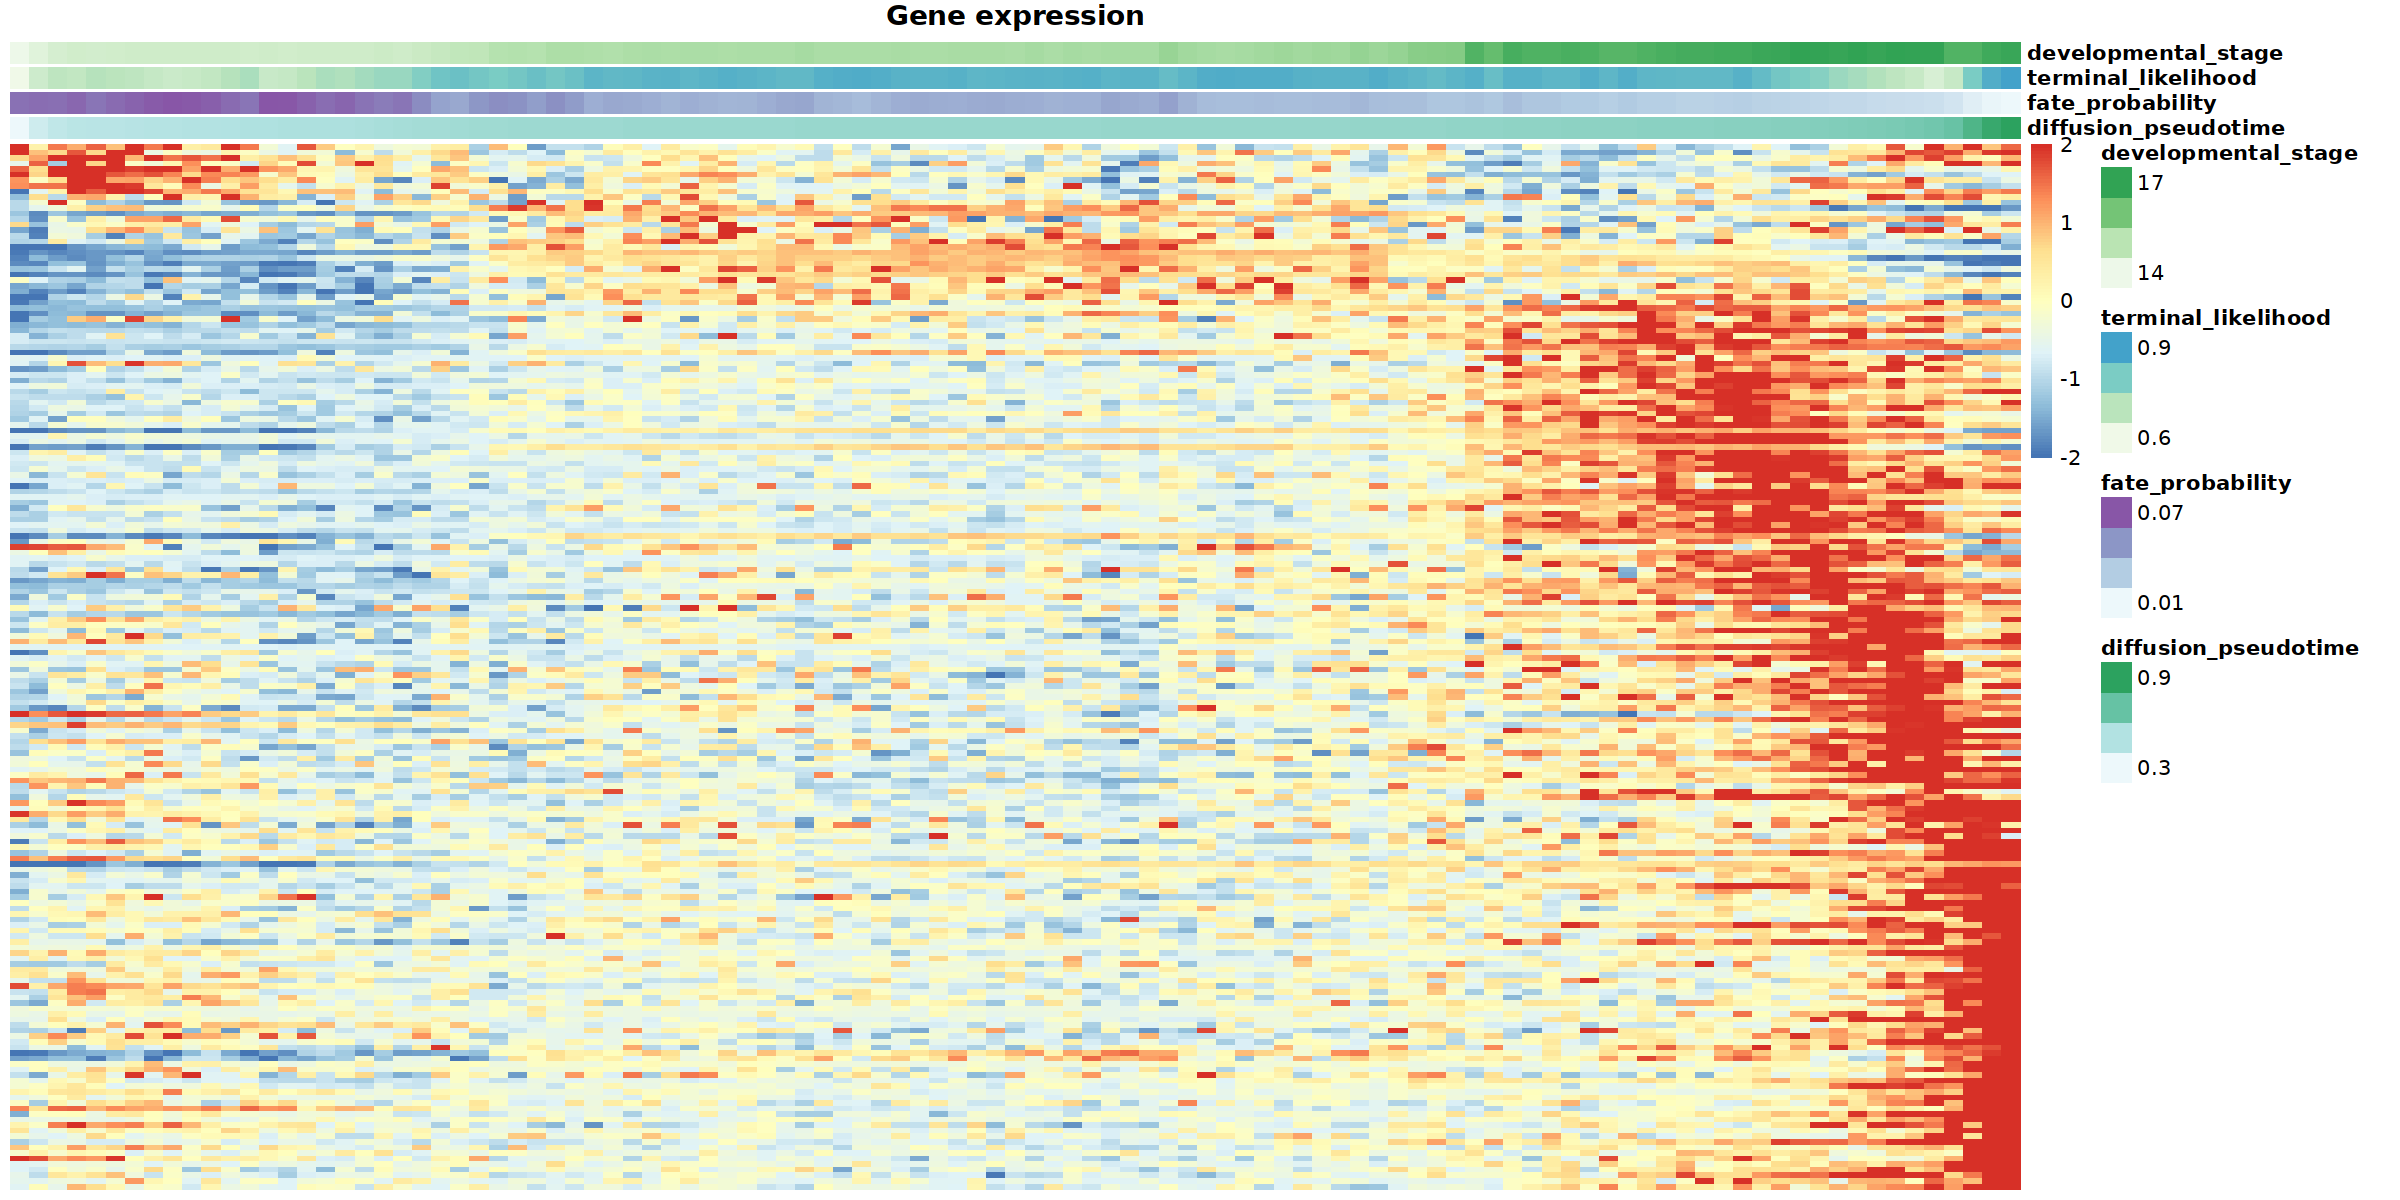

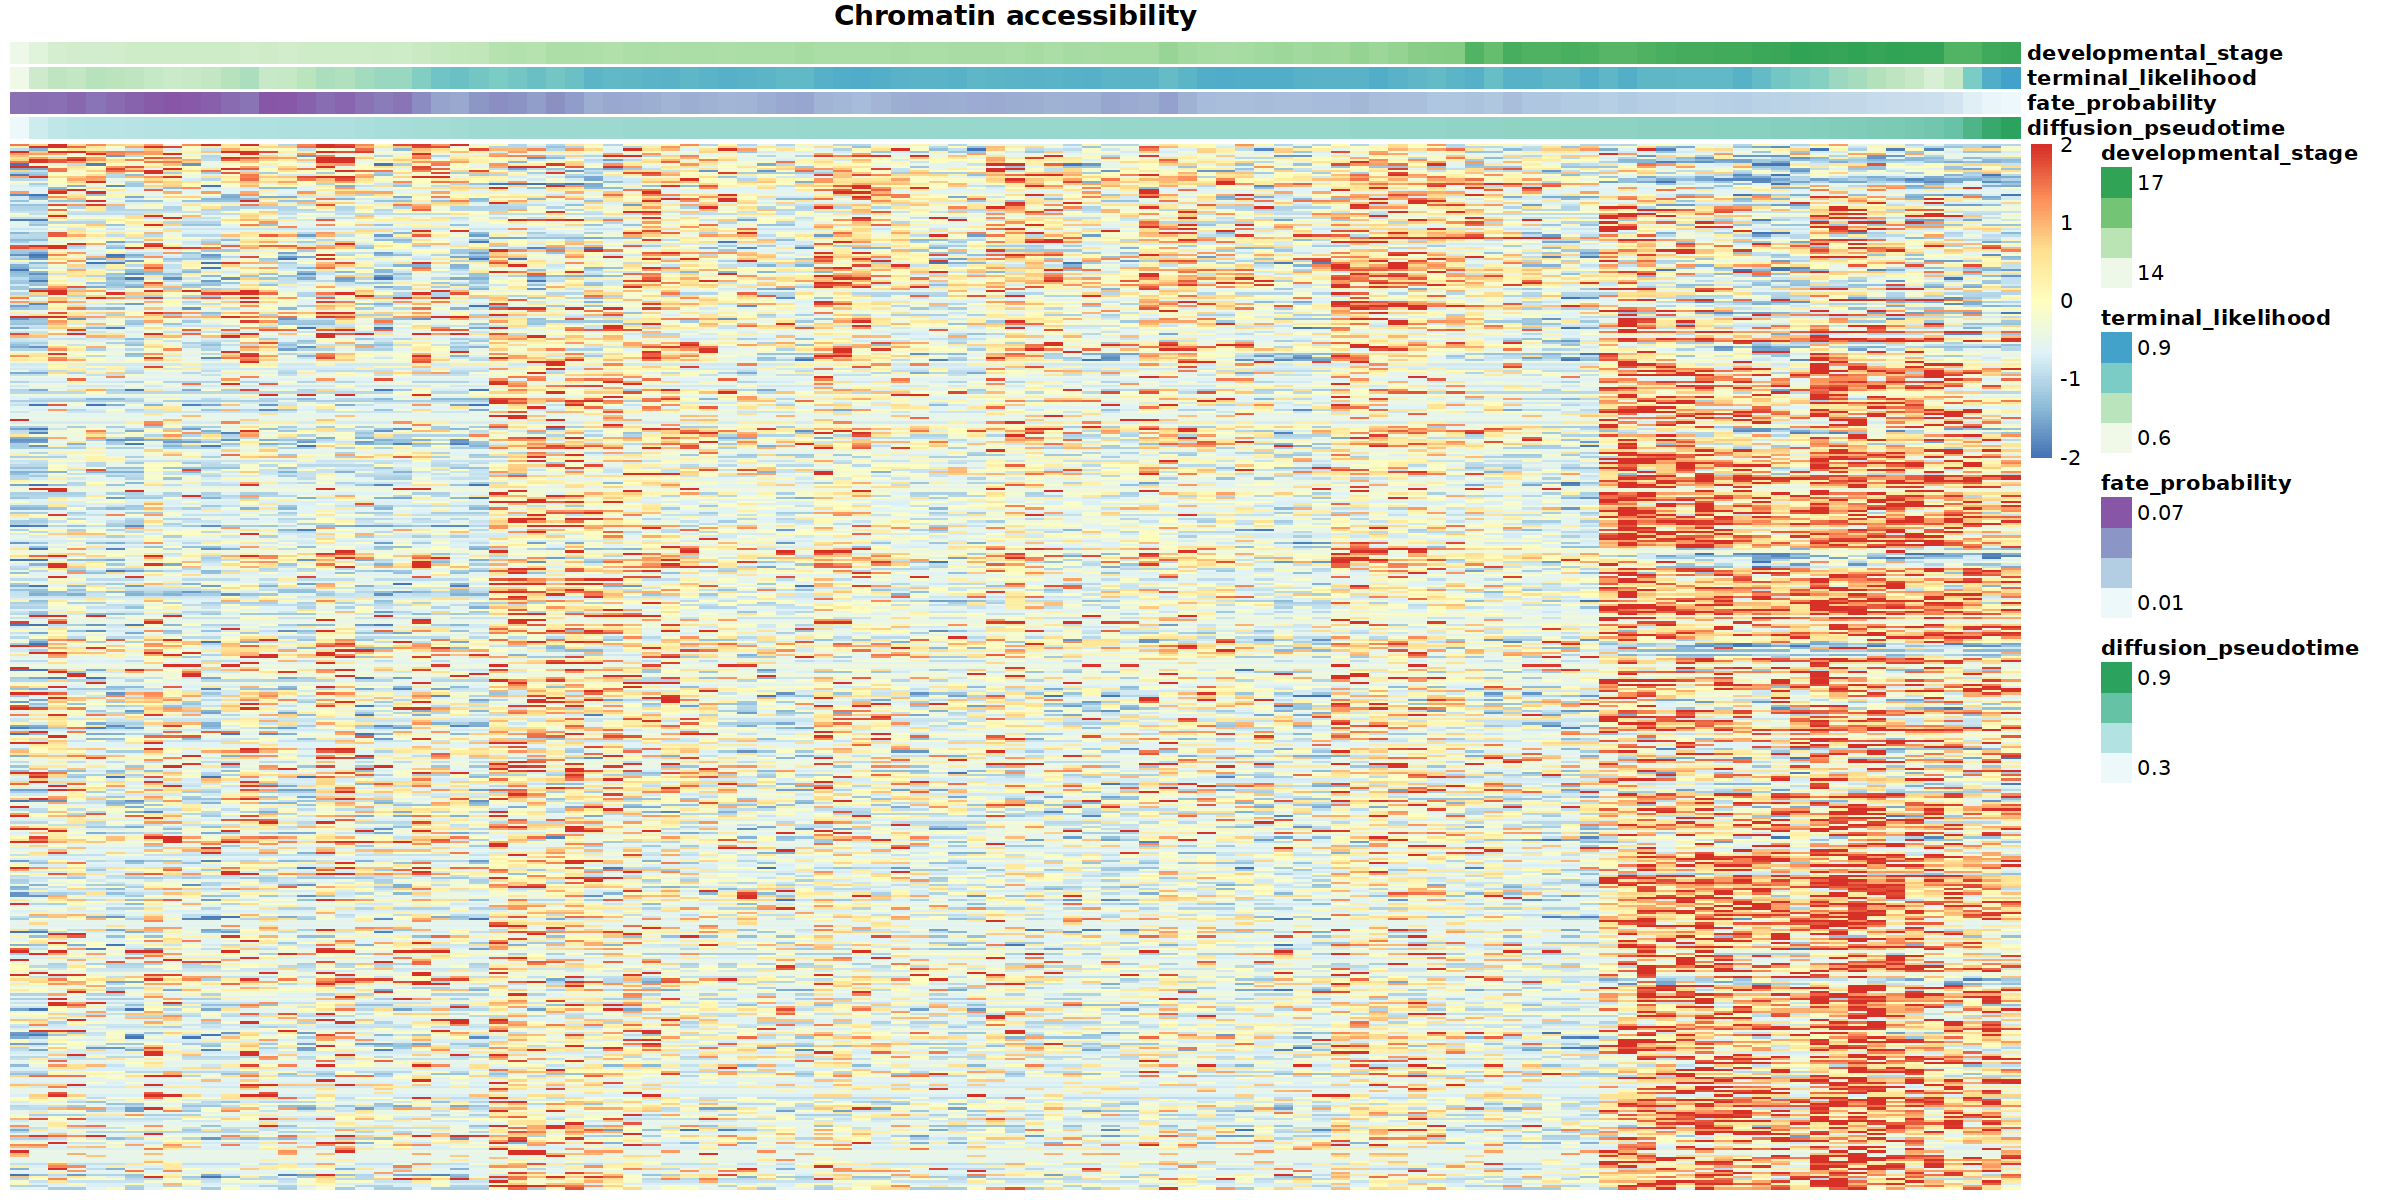

In [45]:
options(repr.plot.width=16, repr.plot.height=8, repr.plot.res = 150)
p1 <- pheatmap(means_rna[rowOrd_rna,],cluster_rows = F, cluster_cols = F, scale = "row",         # gaps_row = c(cut1,cut2),
         breaks=seq(-2,2,length=101),annotation_col = anno_col,show_colnames = F, show_rownames = F, main='Gene expression')
p2 <- pheatmap(means_atac,cluster_rows = F, cluster_cols = F, scale = "row",         # gaps_row = c(cut1,cut2),
         breaks=seq(-2,2,length=101), annotation_col = anno_col,show_colnames = F, show_rownames = F, main='Chromatin accessibility')